In [1]:
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import torch
import torch.nn as nn
from utils.metrics import *
from utils import data
import matplotlib.pyplot as plt

73.43318271095573 72.40827174451194
(3, 752, 657)


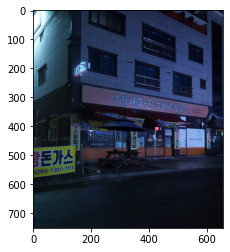

In [20]:
# PSNR sanity check
dataset = data.RealBlurDataset()
print(calculate_psnr(*dataset[0], input_order='CHW'), calculate_psnr(*dataset[1], input_order='CHW'))
print(dataset[0][0].shape)
plt.imshow(dataset[0][1].transpose((1, 2, 0)))

In [15]:
dataset[0][0].shape, dataset[1][0].shape

((3, 752, 657), (3, 760, 667))

In [18]:
a = torch.arange(64).reshape((8, 8)).unsqueeze(0)
a

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7],
         [ 8,  9, 10, 11, 12, 13, 14, 15],
         [16, 17, 18, 19, 20, 21, 22, 23],
         [24, 25, 26, 27, 28, 29, 30, 31],
         [32, 33, 34, 35, 36, 37, 38, 39],
         [40, 41, 42, 43, 44, 45, 46, 47],
         [48, 49, 50, 51, 52, 53, 54, 55],
         [56, 57, 58, 59, 60, 61, 62, 63]]])

In [20]:
a.unfold(1, 2, 2).unfold(2, 2, 2)[0, 3, 3]

tensor([[54, 55],
        [62, 63]])